### Package import

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from matplotlib import pylab as plt
from sklearn import tree, preprocessing
from sklearn import linear_model, model_selection, metrics, random_projection
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sqlalchemy import create_engine

### Data Preprocessing

#### Data Loading

In [2]:
# file path might need to redefined based on user's file location
my_conn = create_engine("sqlite:////Users/Yi/Desktop/Wildfire/FPA_FOD_20221014.sqlite")

In [3]:
# present all the tables in the dataset
r_set = my_conn.execute('''select name from sqlite_master where type = 'table' ''')
for row in r_set:
    print(row)

('spatial_ref_sys',)
('spatialite_history',)
('sqlite_sequence',)
('geometry_columns',)
('views_geometry_columns',)
('virts_geometry_columns',)
('geometry_columns_statistics',)
('views_geometry_columns_statistics',)
('virts_geometry_columns_statistics',)
('geometry_columns_field_infos',)
('views_geometry_columns_field_infos',)
('virts_geometry_columns_field_infos',)
('geometry_columns_time',)
('geometry_columns_auth',)
('views_geometry_columns_auth',)
('virts_geometry_columns_auth',)
('sql_statements_log',)
('SpatialIndex',)
('NWCG_UnitIdActive_20200123',)
('Fires',)
('idx_Fires_Shape',)
('idx_Fires_Shape_rowid',)
('idx_Fires_Shape_node',)
('idx_Fires_Shape_parent',)


In [4]:
# select related columns from table of interest
df_raw = pd.read_sql_query("SELECT FIRE_YEAR, NWCG_GENERAL_CAUSE, LATITUDE, LONGITUDE, STATE, DISCOVERY_DATE, FIRE_SIZE, FIRE_SIZE_CLASS FROM 'Fires'", my_conn)

#### Exploratory Data Analysis

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303566 entries, 0 to 2303565
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   FIRE_YEAR           int64  
 1   NWCG_GENERAL_CAUSE  object 
 2   LATITUDE            float64
 3   LONGITUDE           float64
 4   STATE               object 
 5   DISCOVERY_DATE      object 
 6   FIRE_SIZE           float64
 7   FIRE_SIZE_CLASS     object 
dtypes: float64(3), int64(1), object(4)
memory usage: 140.6+ MB


In [6]:
df_raw.describe()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE
count,2.303566e+06,2.303566e+06,2.303566e+06,2.303566e+06
mean,2.006167e+03,3.696623e+01,-9.635792e+01,7.816088e+01
std,8.044361e+00,6.008260e+00,1.664360e+01,2.630832e+03
min,1.992000e+03,1.793972e+01,-1.788026e+02,1.000000e-05
25%,2.000000e+03,3.301390e+01,-1.110361e+02,1.000000e-01
50%,2.006000e+03,3.572250e+01,-9.347009e+01,8.000000e-01
75%,2.013000e+03,4.089029e+01,-8.251000e+01,3.000000e+00
max,2.020000e+03,7.033060e+01,-6.525694e+01,6.627000e+05


In [7]:
df_raw.head(10)

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS
0,2005,Power generation/transmission/distribution,40.036944,-121.005833,CA,2/2/2005,0.10,A
1,2004,Natural,38.933056,-120.404444,CA,5/12/2004,0.25,A
2,2004,Debris and open burning,38.984167,-120.735556,CA,5/31/2004,0.10,A
3,2004,Natural,38.559167,-119.913333,CA,6/28/2004,0.10,A
4,2004,Natural,38.559167,-119.933056,CA,6/28/2004,0.10,A
5,2004,Natural,38.635278,-120.103611,CA,6/30/2004,0.10,A
6,2004,Natural,38.688333,-120.153333,CA,7/1/2004,0.10,A
7,2005,Debris and open burning,40.968056,-122.433889,CA,3/8/2005,0.80,B
8,2005,Debris and open burning,41.233611,-122.283333,CA,3/15/2005,1.00,B
9,2004,Natural,38.548333,-120.149167,CA,7/1/2004,0.10,A


<AxesSubplot:title={'center':'Fire Cause Frequency Plot'}>

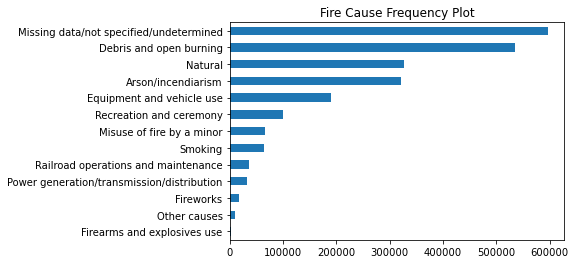

In [8]:
df_raw['NWCG_GENERAL_CAUSE'].value_counts(ascending=True).plot(kind='barh', title='Fire Cause Frequency Plot')

<AxesSubplot:title={'center':'Top 10 States with Most Wildfires'}>

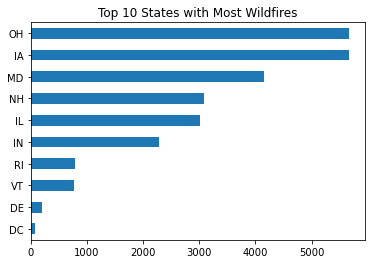

In [9]:
df_raw['STATE'].value_counts(ascending=True).head(10).plot(kind='barh', title='Top 10 States with Most Wildfires')

<AxesSubplot:title={'center':'Geometric Distribution of Wildfires'}, xlabel='LONGITUDE', ylabel='LATITUDE'>

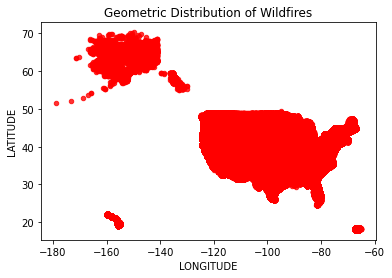

In [10]:
df_raw.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', color='red', alpha=0.8, title='Geometric Distribution of Wildfires')

#### Data Preprocessing

In [11]:
# check null value
df_raw.isnull().sum()

FIRE_YEAR             0
NWCG_GENERAL_CAUSE    0
LATITUDE              0
LONGITUDE             0
STATE                 0
DISCOVERY_DATE        0
FIRE_SIZE             0
FIRE_SIZE_CLASS       0
dtype: int64

In [12]:
# reduce number of classes (cause)
all_causes = set(df_raw['NWCG_GENERAL_CAUSE'])
for c in all_causes:
    print(c)    

# reduce the number of classes of the fire causes
CATEGORY = {}
CATEGORY[0] = ['Natural']
CATEGORY[1] = ['Power generation/transmission/distribution', 
               'Fireworks', 
               'Firearms and explosives use', 
               'Debris and open burning',
               'Smoking',
               'Railroad operations and maintenance',
               'Misuse of fire by a minor',
               'Equipment and vehicle use',
               'Recreation and ceremony']
CATEGORY[2] = ['Arson/incendiarism']
CATEGORY[3] = ['Missing data/not specified/undetermined', 'Other causes']


def set_label(cause):
    if cause in CATEGORY[0]:
        res = 0
    elif cause in CATEGORY[1]:
        res = 1
    elif cause in CATEGORY[2]:
        res = 2
    else:
        res = 3
    return res

df_raw['LABEL'] = df_raw['NWCG_GENERAL_CAUSE'].apply(lambda c: set_label(c))

Railroad operations and maintenance
Arson/incendiarism
Recreation and ceremony
Equipment and vehicle use
Firearms and explosives use
Debris and open burning
Power generation/transmission/distribution
Fireworks
Other causes
Smoking
Misuse of fire by a minor
Missing data/not specified/undetermined
Natural


[Text(0, 0, 'Accidental'),
 Text(0, 1, 'Other'),
 Text(0, 2, 'Natural'),
 Text(0, 3, 'Deliberate')]

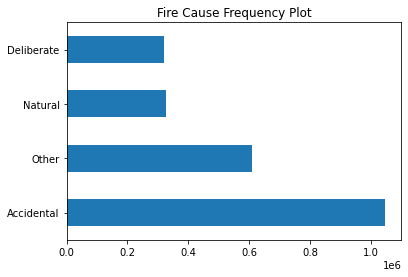

In [13]:
df_raw['LABEL'].value_counts().plot(kind='barh', title='Fire Cause Frequency Plot').set_yticklabels(['Accidental', 'Other', 'Natural', 'Deliberate'])

In [14]:
df = df_raw.copy()
state_encoder = LabelEncoder()
size_encoder = LabelEncoder() 
week_encoder = LabelEncoder()

# use label encoder to encode the date information
df['STATE'] = state_encoder.fit_transform(df['STATE'])
df['FIRE_SIZE_CLASS'] = size_encoder.fit_transform(df['FIRE_SIZE_CLASS'])

# extract date information from 'DISCOVERY_DATE' 
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'])
df['DAY_OF_WEEK'] = df['DISCOVERY_DATE'].dt.day_name()
df['DAY_OF_WEEK'] = week_encoder.fit_transform(df['DAY_OF_WEEK'])
df['MONTH'] = df['DISCOVERY_DATE'].dt.month
df['DISCOVERY_DATE'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).to_julian_date()
df

,FIRE_YEAR,NWCG_GENERAL_CAUSE,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LABEL,DAY_OF_WEEK,MONTH
0,2005,Power generation/transmission/distribution,40.036944,-121.005833,4,2453403.5,0.10,0,1,6,2
1,2004,Natural,38.933056,-120.404444,4,2453137.5,0.25,0,0,6,5
2,2004,Debris and open burning,38.984167,-120.735556,4,2453156.5,0.10,0,1,1,5
3,2004,Natural,38.559167,-119.913333,4,2453184.5,0.10,0,0,1,6
4,2004,Natural,38.559167,-119.933056,4,2453184.5,0.10,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...
2303561,2020,Natural,39.037890,-108.959500,5,2459005.5,1.00,1,0,0,6
2303562,2020,Missing data/not specified/undetermined,37.148611,-119.503056,4,2459041.5,100.00,3,3,2,7
2303563,2020,Natural,46.151370,-114.442800,26,2459088.5,50.00,2,0,4,8
2303564,2020,Natural,46.670340,-120.114500,48,2459078.5,24892.00,6,0,1,8


In [15]:
# group the data by different state
df_by_state = {}
df_group = df.groupby(by='STATE')
for key, value in df_group:
    df_by_state[key] = value

Based on the value count of the different causes, the dataset is highly unbalanced, we need to oversample the less common classes. Here we perform a **Synthetic Minority Oversampling Technique (SMOTE)** to balance the dataset

In [16]:
# reduce sample size and split the dataset to form X and y and do resampling
reduced_df = df.sample(n=200000, random_state=10).reset_index(drop=True)
X, y = reduced_df.drop(['NWCG_GENERAL_CAUSE', 'LABEL'], axis=1), reduced_df['LABEL']

# oversample the minority classes
smote = SMOTE(random_state=10)
X, y = smote.fit_resample(X, y)

# split training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# standardize the data
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

<AxesSubplot:>

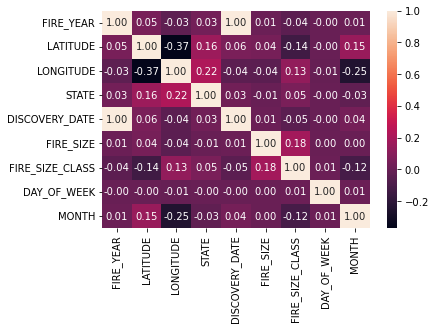

In [17]:
# variable correlation heatmap
X_train_df = pd.DataFrame(data=X_train, columns=['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'STATE', 'DISCOVERY_DATE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'DAY_OF_WEEK', 'MONTH'])
sns.heatmap(X_train_df.corr(), annot=True, fmt=".2f")

### Machine Learning Model Training

#### Helper Functions

In [18]:
# draw the confusion matrix
def draw_confusion(model, verbose=False, multi=False):
    y_pred = model.predict(X_test)
    if multi:
        y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0, 1, 2, 3])
    cmn = np.round(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], 4)
    if verbose:
        print("Confusion matrix is", cmn)

    ax = plt.subplot()
    sns.heatmap(cmn, annot=True, fmt='g', ax=ax)

    ax.set_xlabel("Predicted Cause Label")
    ax.set_ylabel("True Cause Label")
    labels = ['Natural', 'Accidental', 'Deliberate', 'Other']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()

#### Random Forest

In [19]:
clf_rf = RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print("Vannila random forest classification accuracy", clf_rf.score(X_test, y_test))

Vannila random forest classification accuracy 0.752986113655516


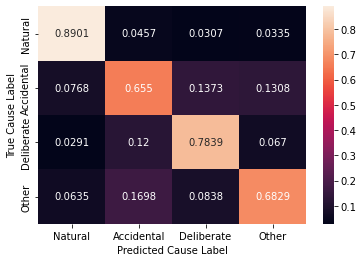

In [20]:
# visualization of each class's accuracy
draw_confusion(clf_rf)

In [21]:
# use a K-fold cross validation to examine the model, here K=5
scores_rf = cross_val_score(RandomForestClassifier(n_estimators=50), X, y, cv=5)
print("The average scores is:", np.mean(scores_rf))
print("The standard deviation of scores is:", np.std(scores_rf))

The average scores is: 0.7555125520662995
The standard deviation of scores is: 0.04219710348017042


#### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
clf_logit = LogisticRegression(multi_class='ovr').fit(X_train, y_train)
print("Logistic classification accuracy", clf_logit.score(X_test, y_test))

Logistic classification accuracy 0.4371358956508995


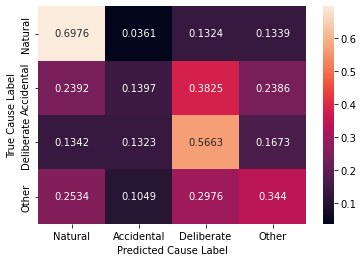

In [23]:
draw_confusion(clf_logit)

In [24]:
# use a K-fold cross validation to examine the model, here K=5
scores_logit = cross_val_score(LogisticRegression(multi_class='ovr'), X, y, cv=5)
print("The average scores is:", np.mean(scores_logit))
print("The standard deviation of scores is:", np.std(scores_logit))

The average scores is: 0.2588402444720618
The standard deviation of scores is: 0.0004265723325476936


#### Gradient Boosting Tree

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gbt = GradientBoostingClassifier().fit(X_train, y_train)
print("Gradient boosting tree accuracy", clf_gbt.score(X_test, y_test))

Gradient boosting tree accuracy 0.6275235408346462


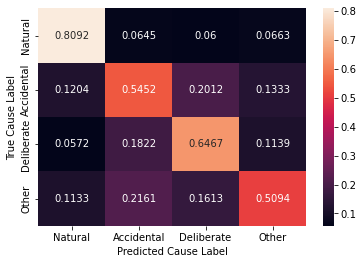

In [26]:
draw_confusion(clf_gbt)

In [27]:
# use a K-fold cross validation to examine the model, here K=5
scores_gbt = cross_val_score(GradientBoostingClassifier(), X, y, cv=5)
print("The average scores is:", np.mean(scores_gbt))
print("The standard deviation of scores is:", np.std(scores_gbt))

The average scores is: 0.6207132211739473
The standard deviation of scores is: 0.02971669839763537


#### Support Vector Machine

In [28]:
from sklearn import svm
clf_svm = svm.LinearSVC(dual=False, max_iter=1500)
clf_svm.fit(X_train, y_train)
print("Support vector machine accuracy", clf_svm.score(X_test, y_test))

Support vector machine accuracy 0.4358901549847946


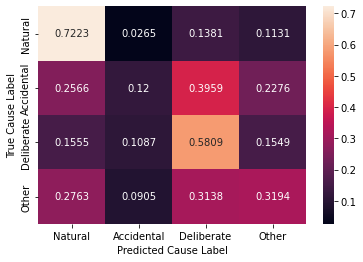

In [29]:
draw_confusion(clf_svm)

In [30]:
# use a K-fold cross validation to examine the model, here K=5
scores_svm = cross_val_score(svm.LinearSVC(dual=False, max_iter=1500), X, y, cv=5)
print("The average scores is:", np.mean(scores_svm))
print("The standard deviation of scores is:", np.std(scores_svm))

The average scores is: 0.25903535384902443
The standard deviation of scores is: 0.0008945916567660703


#### Feed Forward Neural Networks

In [20]:
# build neural network
def build_nn():
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(9,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(32, activation='sigmoid'),
        tf.keras.layers.Dense(4)
    ])

nn_model = build_nn()
nn_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [30]:
K = 5
scores_nn = []
for i in range(K):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    std = StandardScaler()
    X_train = std.fit_transform(X_train)
    X_test = std.transform(X_test)
    nn_model.fit(X_train, y_train, epochs=10)

    # evaluate the model
    test_loss, test_score = nn_model.evaluate(X_test, y_test, verbose=2)
    print("Iteration %f Neural network accuracy %f" % (i, test_score))
    scores_nn.append(test_score)

Epoch 1/10
7961/7961 [==============================] - 20s 2ms/step - loss: 1.0559 - accuracy: 0.5395
Epoch 2/10
7961/7961 [==============================] - 15s 2ms/step - loss: 0.9743 - accuracy: 0.5859
Epoch 3/10
7961/7961 [==============================] - 15s 2ms/step - loss: 0.9514 - accuracy: 0.5976
Epoch 4/10
7961/7961 [==============================] - 13s 2ms/step - loss: 0.9402 - accuracy: 0.6040
Epoch 5/10
7961/7961 [==============================] - 13s 2ms/step - loss: 0.9323 - accuracy: 0.6073
Epoch 6/10
7961/7961 [==============================] - 13s 2ms/step - loss: 0.9266 - accuracy: 0.6112
Epoch 7/10
7961/7961 [==============================] - 13s 2ms/step - loss: 0.9217 - accuracy: 0.6135
Epoch 8/10
7961/7961 [==============================] - 13s 2ms/step - loss: 0.9170 - accuracy: 0.6158
Epoch 9/10
7961/7961 [==============================] - 13s 2ms/step - loss: 0.9133 - accuracy: 0.6176
Epoch 10/10
7961/7961 [==============================] - 13s 2ms/step - l

In [31]:
print("The average scores is:", np.mean(scores_nn))
print("The standard deviation of scores is:", np.std(scores_nn))

The average scores is: 0.6298794507980346
The standard deviation of scores is: 0.005881403721168774


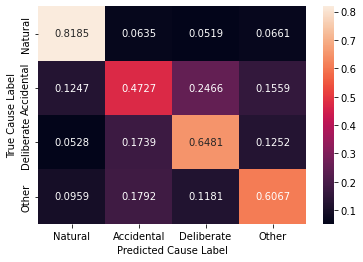

In [32]:
draw_confusion(nn_model, multi=True)

### Save Trained Models

In [34]:
# save input scaler
joblib.dump(std, 'standard_scaler.pkl')

# save input encoder
joblib.dump(state_encoder, 'state_encoder.pkl')
joblib.dump(size_encoder, 'size_encoder.pkl')
joblib.dump(week_encoder, 'week_encoder.pkl')

# save machine learning models
joblib.dump(clf_rf, 'random_forest.pkl')
joblib.dump(clf_gbt, 'gbt.pkl')
joblib.dump(clf_logit, 'logistic.pkl')
joblib.dump(clf_svm, 'svm.pkl')

"""
scaler = joblib.load(scaler.pkl)
encoder = joblib.load(encoder.pkl)
model = joblib.load(model.pkl)
X_test[categorical] = encoder.fit(X_test[categorical])
X_test = scaler.transform(X_test)
model.predict(X_test)
"""


'\nscaler = joblib.load(scaler.pkl)\nencoder = joblib.load(encoder.pkl)\nmodel = joblib.load(model.pkl)\nX_test[categorical] = encoder.fit(X_test[categorical])\nX_test = scaler.transform(X_test)\nmodel.predict(X_test)\n'